In [11]:

from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.layers import Dense, Dropout
import tensorflow as tf
class MLPRegressor(tf.keras.Model):

    def __init__(self,input_shape):
        super().__init__()
        self.dense_1 = Dense(units=10, input_shape=input_shape, activation='relu')
        self.dropout_1 = Dropout(rate=0.1)
        self.dense_2 = Dense(units=10, activation='relu')
        self.dropout_2 = Dropout(rate=0.1)
        self.regressor = Dense(units=1, activation='linear')


    @staticmethod
    def get_compiled_model(input_shape):
        model = MLPRegressor(input_shape)
        model.compile(optimizer='adam', loss='mse')
        return model

    def call(self,inputs,**kwargs):
        x = self.dense_1(inputs)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        return self.regressor(x)


In [7]:
import pandas as pd

def prepare_for_training(df: pd.DataFrame):
    target_col = list(df.columns)[-1]
    x_df = df.drop(columns=target_col)
    x = x_df.values
    y = df[target_col].values

    return x,y

def rescale_mean_temp(data):
    array = np.vstack((data, data, data, data, data)).T
    return std_scaler.inverse_transform(array)[:, -1]

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Epoch 1/300
39/39 [==============================] - 1s 6ms/step - loss: 0.7713 - val_loss: 0.4351 - lr: 0.0010
Epoch 2/300
39/39 [==============================] - 0s 3ms/step - loss: 0.3751 - val_loss: 0.2110 - lr: 0.0010
Epoch 3/300
39/39 [==============================] - 0s 3ms/step - loss: 0.2143 - val_loss: 0.1742 - lr: 0.0010
Epoch 4/300
39/39 [==============================] - 0s 3ms/step - loss: 0.1769 - val_loss: 0.1589 - lr: 0.0010
Epoch 5/300
39/39 [==============================] - 0s 3ms/step - loss: 0.1566 - val_loss: 0.1471 - lr: 0.0010
Epoch 6/300
39/39 [==============================] - 0s 3ms/step - loss: 0.1414 - val_loss: 0.1371 - lr: 0.0010
Epoch 7/300
39/39 [==============================] - 0s 3ms/step - loss: 0.1296 - val_loss: 0.1289 - lr: 0.0010
Epoch 8/300
39/39 [==============================] - 0s 3ms/step - loss: 0.1202 - val_loss: 0.1224 - lr: 0.0010
Epoch 9/300
39/39 [==============================] - 0s 3ms/step - loss: 0.1122 - val_loss: 0.1172 - lr:

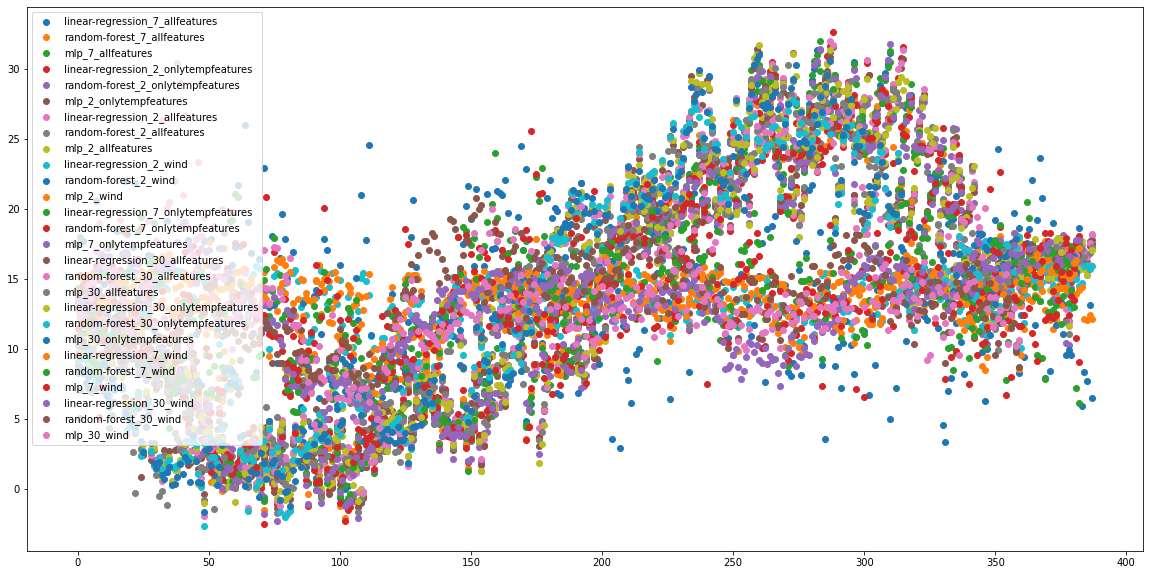

In [17]:
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import glob
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

std_scaler=joblib.load('./preproc/stdscaler.bin')
from matplotlib.pyplot import figure

figure(figsize=(20, 10))
for training_set_fname in glob.glob('./preproc/*train.csv'):
    train_df = pd.read_csv(training_set_fname,index_col=0)
    test_df = pd.read_csv(training_set_fname.replace('train','test'),index_col=0)

    training_set_fname = training_set_fname[len('./preproc/'):]

    from_prev_n_days = int(training_set_fname.split('_')[0].replace('prev','',)) + 1 # if == 2 then the n+1th day is predicted from the nth and n-1th
    category = training_set_fname.split('_')[1]

    x_train,y_train = prepare_for_training(train_df)
    x_test,y_test = prepare_for_training(test_df)
    np.save(f'./predictions/true_labels-{from_prev_n_days}-{category}.npy',y_test,allow_pickle=True)

    statistical_models = {
        'linear_regression': LinearRegression(),
        'random_forest_regression': RandomForestRegressor(max_depth=4,n_estimators=100)
    }

    #linear regression
    lin_reg = LinearRegression()
    lin_reg.fit(x_train,y_train)
    preds = lin_reg.predict(x_test)
    preds = rescale_mean_temp(preds)
    plt.scatter(range(len(preds)),preds,label=f'linear-regression_{from_prev_n_days}_{category}')
    np.save(f'./predictions/linear_regression/preds-prev{from_prev_n_days}-{category}.npy',preds,allow_pickle=True)
    np.save(f'./predictions/linear_regression/coefs-prev{from_prev_n_days}-{category}.npy',lin_reg.coef_,allow_pickle=True)

    #random forest
    forest = RandomForestRegressor()
    forest.fit(x_train,y_train)
    preds = forest.predict(x_test)
    preds = rescale_mean_temp(preds)
    plt.scatter(range(len(preds)),preds,label=f'random-forest_{from_prev_n_days}_{category}')
    np.save(f'./predictions/random_forest/preds-prev{from_prev_n_days}-{category}.npy',preds,allow_pickle=True)
    np.save(f'./predictions/random_forest/importances-prev{from_prev_n_days}-{category}.npy',forest.feature_importances_,allow_pickle=True)

    #MLP training
    mlp = MLPRegressor.get_compiled_model(input_shape=x_train.shape[1:])
    callbacks = [EarlyStopping(monitor='val_loss',patience=10), ReduceLROnPlateau(monitor='val_loss',patience=5, factor=0.5)]
    history = mlp.fit(x_train,y_train, validation_split=0.2, shuffle=False, callbacks=callbacks,epochs=300)
    preds = mlp.predict(x_test).flatten()
    preds = rescale_mean_temp(preds)
    plt.scatter(range(len(preds)),preds,label=f'mlp_{from_prev_n_days}_{category}')
    np.save(f'./predictions/mlp/preds-prev{from_prev_n_days}-{category}.npy',preds,allow_pickle=True)
    pd.DataFrame(history.history).to_csv(f'./predictions/mlp/train_hist-prev{from_prev_n_days}-{category}.csv',index=False)
plt.legend()

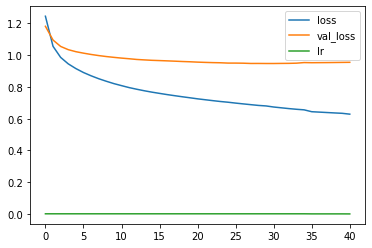

In [18]:
pd.DataFrame(history.history).plot()